<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
#np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read, Split train_val & oversample train set


In [3]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']
df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.1, random_state = 415);
train_df.head()

,Image name,Retinopathy grade
118,IDRiD_119,4
391,IDRiD_392,4
41,IDRiD_042,2
44,IDRiD_045,2
216,IDRiD_217,0


In [4]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 371


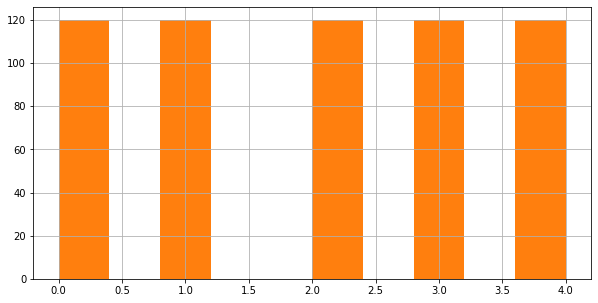

In [5]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import multiprocessing

In [7]:
image_names = train_df['Image name'];
im_size = 224;

train_labels = [];
for label in train_df['Retinopathy grade']:
    for i in range(2): # 2 times for data augmentation
      train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((2*len(train_df['Image name']),224,224,3))

index=0
for image_name in image_names:
    #read image
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index] = img
    #rot 180
    train_images[index + 1] = np.rot90(np.rot90(img))
    
    index = index + 2

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  1200
(1200, 224, 224, 3)
(1200, 5)


array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]])

In [8]:
train_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    #brightness_range=[0.,0.01],
    #zca_whitening	=True,
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(train_images)

## Read test_df


In [9]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


In [10]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 224;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = cv2.imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 224, 224, 3)
(103, 5)


In [11]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of test set ",len(val_image_names))
im_size = 224;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);

val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of test set  42
(42, 224, 224, 3)
(42, 5)


In [12]:
from sklearn.utils import shuffle

train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (1200, 224, 224, 3)
train y size  (1200, 5)
test x size  (103, 224, 224, 3)
test y size  (103, 5)
val x size  (42, 224, 224, 3)
val y size  (42, 5)


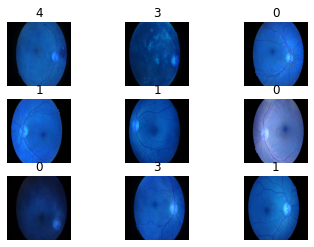

In [13]:
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(train_images[2*i+1])
  plt.title("{}".format(np.argmax(train_labels[2*i+1]))) 
  plt.axis('off')

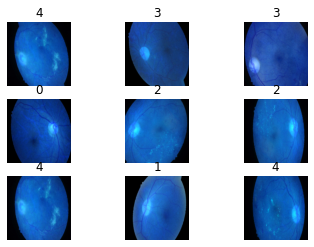

In [14]:
x=train_datagen.flow(train_images, train_labels,batch_size=9,shuffle=True)
for i,(img,lbl) in enumerate(x):
  for j in range(9):
    ax=plt.subplot(3,3,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break

In [15]:
from keras.models import Sequential
from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

In [16]:
def build_model(num_classes):
    random.seed = 1358
    tf.seed = 1358
    tf.random.set_seed(1358)
    IMG_SIZE=224
    NUM_CLASSES=num_classes
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = DenseNet121(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = Flatten(name="flatten")(model.output)
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_1")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="DenseNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [17]:
from keras.utils.layer_utils import count_params
random.seed = 1358
tf.seed = 1358
tf.random.set_seed(1358)
model=build_model(5)
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

29089792/29084464 [==============================] - 0s 0us/step
Total params: 19,949,893
Trainable params: 12,912,389
Non-trainable params: 7,037,504


In [18]:
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 10)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 100, validation_data = (val_images, val_labels), callbacks = [early_stopping], shuffle = True);

Epoch 1/100
75/75 [==============================] - 55s 227ms/step - loss: 1.8002 - accuracy: 0.2420 - val_loss: 1.4371 - val_accuracy: 0.3333
Epoch 2/100
75/75 [==============================] - 13s 169ms/step - loss: 1.3842 - accuracy: 0.3898 - val_loss: 1.3724 - val_accuracy: 0.3095
Epoch 3/100
75/75 [==============================] - 13s 171ms/step - loss: 1.1979 - accuracy: 0.4767 - val_loss: 1.1943 - val_accuracy: 0.3571
Epoch 4/100
75/75 [==============================] - 13s 171ms/step - loss: 1.1621 - accuracy: 0.4868 - val_loss: 1.1657 - val_accuracy: 0.3333
Epoch 5/100
75/75 [==============================] - 13s 173ms/step - loss: 1.0669 - accuracy: 0.5427 - val_loss: 1.3186 - val_accuracy: 0.3810
Epoch 6/100
75/75 [==============================] - 13s 169ms/step - loss: 1.0414 - accuracy: 0.5589 - val_loss: 1.2972 - val_accuracy: 0.4286
Epoch 7/100
75/75 [==============================] - 13s 170ms/step - loss: 1.0307 - accuracy: 0.5272 - val_loss: 1.2523 - val_accuracy:

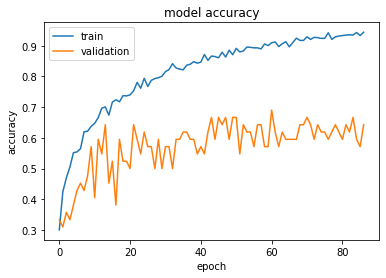

In [19]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

4/4 [==============================] - 1s 421ms/step - loss: 2.0189 - accuracy: 0.4369
Loss = 2.0189456939697266
Test accuracy = 0.43689319491386414
[[21  6  4  3  0]
 [ 3  1  1  0  0]
 [ 4  3  9 11  5]
 [ 2  0  3 10  4]
 [ 1  0  1  7  4]]


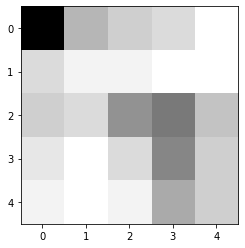

In [22]:
preds = model.evaluate(test_images, test_labels)
print("Loss = " + str(preds[0]))
print("Test accuracy = " + str(preds[1]))
pred_y_=model.predict(test_images)
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')

[[14  0  0  0]
 [ 3  7  7  2]
 [ 1  1  2  1]
 [ 0  0  0  4]]
0.6428571428571429  acuracy


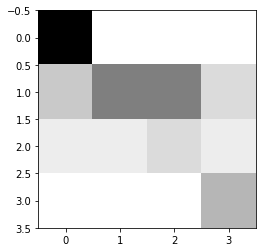

In [21]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_=model.predict(val_images)
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary') 
score=accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

## unfreeze and train


In [31]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:]=='bn':
    layer.trainable=False
    count+=1
print(count," layers of bn freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

121  layers of bn freezed
Total params: 19,949,893
Trainable params: 19,782,597
Non-trainable params: 167,296


In [36]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
opt = keras.optimizers.Adam(learning_rate = 5e-8, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=16,shuffle=True),steps_per_epoch=len(train_images) / 16,
               epochs = 10, validation_data = (val_images, val_labels));

Epoch 1/10
75/75 [==============================] - 26s 252ms/step - loss: 0.1358 - accuracy: 0.9603 - val_loss: 1.4147 - val_accuracy: 0.6429
Epoch 2/10
75/75 [==============================] - 18s 234ms/step - loss: 0.1586 - accuracy: 0.9431 - val_loss: 1.4017 - val_accuracy: 0.6667
Epoch 3/10
75/75 [==============================] - 17s 231ms/step - loss: 0.1520 - accuracy: 0.9356 - val_loss: 1.3984 - val_accuracy: 0.6667
Epoch 4/10
75/75 [==============================] - 18s 232ms/step - loss: 0.1505 - accuracy: 0.9465 - val_loss: 1.4198 - val_accuracy: 0.6429
Epoch 5/10
75/75 [==============================] - 17s 231ms/step - loss: 0.1311 - accuracy: 0.9575 - val_loss: 1.4385 - val_accuracy: 0.6190
Epoch 6/10
75/75 [==============================] - 17s 231ms/step - loss: 0.1408 - accuracy: 0.9519 - val_loss: 1.4585 - val_accuracy: 0.6190
Epoch 7/10
75/75 [==============================] - 17s 232ms/step - loss: 0.1504 - accuracy: 0.9401 - val_loss: 1.4512 - val_accuracy: 0.6429

4/4 [==============================] - 0s 76ms/step - loss: 2.1590 - accuracy: 0.4757
Loss = 2.158965587615967
Test accuracy = 0.4757281541824341
[[22  6  4  2  0]
 [ 3  0  2  0  0]
 [ 4  2 12  9  5]
 [ 2  0  2  8  7]
 [ 2  0  1  3  7]]


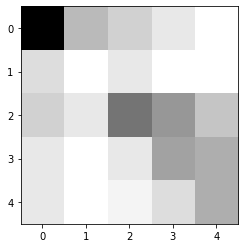

In [37]:
preds = model.evaluate(test_images, test_labels)
print("Loss = " + str(preds[0]))
print("Test accuracy = " + str(preds[1]))
pred_y_=model.predict(test_images)
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')